In [1]:
import os
from pathlib import Path
from datetime import date

import gc
gc.enable()

# snappy imports
import snappy
from snappy import ProductIO, GPF

from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt

In [2]:
# scihub credentials
SCIHUB_UN = %env SCIHUB_UN
SCIHUB_PW = %env SCIHUB_PW

# request parameters - more TBD
REQUEST_AREA = "POLYGON ((6.2567138671875 51.57536261053028, 6.7160797119140625 51.57536261053028, 6.7160797119140625 51.78865666323309, 6.2567138671875 51.78865666323309, 6.2567138671875 51.57536261053028))"

# output directories 
TMP_OUTPUT_DIR = "./output/tmp/"
FNL_OUTPUT_DIR = "./output/"

sentinel_ids = "6492505e-3777-4d00-88d2-d10df3d04955" #"c001a5c2-db67-403e-9ad6-0c6e6a0d903d"

In [3]:
Path(TMP_OUTPUT_DIR).mkdir(parents=True, exist_ok=True)
Path(FNL_OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

In [4]:
# download file (doesn't get downloaded if already exists)
api = SentinelAPI(SCIHUB_UN, SCIHUB_PW)
downloaded_file = api.download(sentinel_ids, directory_path=FNL_OUTPUT_DIR)
downloaded_file

Downloading: 100%|██████████| 1.07G/1.07G [02:32<00:00, 6.99MB/s]
MD5 checksumming: 100%|██████████| 1.07G/1.07G [00:01<00:00, 639MB/s]


{'id': 'c001a5c2-db67-403e-9ad6-0c6e6a0d903d',
 'title': 'S1A_IW_GRDH_1SDV_20200108T171637_20200108T171702_030712_038551_49A5',
 'size': 1066808464,
 'md5': 'CBB5DE416FB75C93F6DE42541C0D5A2B',
 'date': datetime.datetime(2020, 1, 8, 17, 16, 37, 154000),
 'footprint': 'POLYGON((5.876818 51.839985,9.613271 52.246746,9.989347 50.751972,6.371759 50.347618,5.876818 51.839985))',
 'url': "https://scihub.copernicus.eu/apihub/odata/v1/Products('c001a5c2-db67-403e-9ad6-0c6e6a0d903d')/$value",
 'Online': True,
 'Creation Date': datetime.datetime(2020, 1, 9, 0, 29, 1, 991000),
 'Ingestion Date': datetime.datetime(2020, 1, 9, 0, 28, 54, 878000),
 'path': './output/S1A_IW_GRDH_1SDV_20200108T171637_20200108T171702_030712_038551_49A5.zip',
 'downloaded_bytes': 1066808464}

In [5]:
import folium
from shapely import wkt, geometry

dataset_footprint = wkt.loads(downloaded_file['footprint'])
aoi_footprint = wkt.loads(REQUEST_AREA)

m = folium.Map(zoom_starts=3)
m.fit_bounds((
    (dataset_footprint.bounds[1], dataset_footprint.bounds[0]), 
    (dataset_footprint.bounds[3], dataset_footprint.bounds[2])))
folium.GeoJson(dataset_footprint).add_to(m)
folium.GeoJson(aoi_footprint).add_to(m)
m

## Sentinel Preprocessing using Snappy

In [6]:
import shutil
import glob

def delete_output(output_name):
    filepaths = glob.glob(output_name + "*")
    for filepath in filepaths:
        try:
            if os.path.isdir(filepath):
                shutil.rmtree(filepath, ignore_errors=True)
            else: 
                os.remove(filepath)
        except Exception as e:
            print("Error while deleting path: ", filepath, e)

# Some initial configurations
snappy.GPF.getDefaultInstance().getOperatorSpiRegistry().loadOperatorSpis()
sentinel_image = ProductIO.readProduct(downloaded_file['path'])
HashMap = snappy.jpy.get_type('java.util.HashMap')

In [7]:
%%time
# Step: Apply Orbit Files
step1_output = os.path.join(TMP_OUTPUT_DIR, "step1_orbit_files") 

# parameters
parameters = HashMap()

# create and write product
step1_product = GPF.createProduct("Apply-Orbit-File", parameters, sentinel_image)
ProductIO.writeProduct(step1_product, step1_output, 'BEAM-DIMAP')  

CPU times: user 26.5 s, sys: 5.28 s, total: 31.8 s
Wall time: 22.6 s


In [8]:
%%time
# Step: Calibration
step2_output = os.path.join(TMP_OUTPUT_DIR, "step2_calibration")

parameters = HashMap()
parameters.put('outputSigmaBand', True)
parameters.put('outputImageScaleInDb', False)

step2_product = snappy.GPF.createProduct("Calibration", parameters, ProductIO.readProduct(step1_output + ".dim"))
ProductIO.writeProduct(step2_product, step2_output, 'BEAM-DIMAP')

# free space of previous step
delete_output(step1_output)

CPU times: user 1min 28s, sys: 8.22 s, total: 1min 37s
Wall time: 1min 35s


In [9]:
%%time
# Step: Subsetting to area of interest
step3_output = os.path.join(TMP_OUTPUT_DIR, "step3_subset")

WKTReader = snappy.jpy.get_type('com.vividsolutions.jts.io.WKTReader')
geom = WKTReader().read(REQUEST_AREA)

parameters = HashMap()
parameters.put("geoRegion", geom)
parameters.put("outputImageScaleInDb", False)

step3_product = GPF.createProduct("Subset", parameters, ProductIO.readProduct(step2_output + ".dim"))
ProductIO.writeProduct(step3_product, step3_output, 'BEAM-DIMAP')

# free space of previous step
delete_output(step2_output)

CPU times: user 1.95 s, sys: 687 ms, total: 2.64 s
Wall time: 1.82 s


In [10]:
%%time
# Step: Speckle Filtering
step4_output = os.path.join(TMP_OUTPUT_DIR, "step4_speckle")

parameters = HashMap()
parameters.put("filter", "Lee")
parameters.put("filterSizeX", 5)
parameters.put("filterSizeY", 5)

step4_product = GPF.createProduct("Speckle-Filter", parameters, ProductIO.readProduct(step3_output + ".dim"))
ProductIO.writeProduct(step4_product, step4_output, "BEAM-DIMAP")

# free space of previous step
delete_output(step3_output)

CPU times: user 3.95 s, sys: 121 ms, total: 4.07 s
Wall time: 3.39 s


In [11]:
%%time
# Step: Terrain Correction
step5_output = os.path.join(FNL_OUTPUT_DIR, "corrected_output")

parameters = HashMap()
parameters.put('demName', 'SRTM 3Sec') 
parameters.put('pixelSpacingInMeter', 10.0) 
parameters.put('imgResamplingMethod', 'BILINEAR_INTERPOLATION') #BILINEAR_INTERPOLATION NEAREST_NEIGHBOUR
parameters.put('demResamplingMethod', 'BILINEAR_INTERPOLATION') 
# <saveDEM>false</saveDEM>

step5_product = GPF.createProduct("Terrain-Correction", parameters, ProductIO.readProduct(step4_output + ".dim")) 
ProductIO.writeProduct(step5_product, step5_output, 'GeoTIFF-BigTIFF')

# free space of previous step
delete_output(step4_output)

CPU times: user 1min 57s, sys: 3.14 s, total: 2min
Wall time: 1min 42s


In [ ]:
os.remove(downloaded_file['path'])

## Classifying Water Pixels

In [14]:
import os

import rasterio 
import rasterio.features
import rasterio.warp
from rasterio import mask
import numpy as np

import matplotlib.pyplot as plt

/home/hafenkran/dev/tb16/venv/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


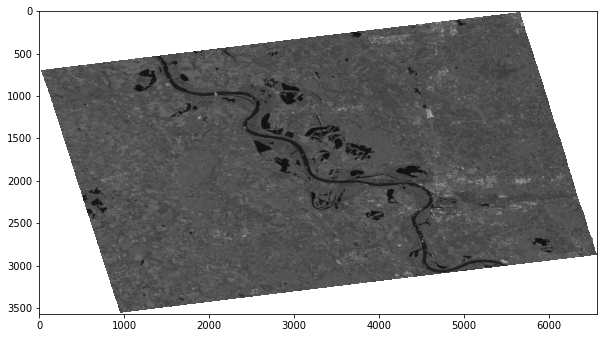

In [15]:
s1_corrected_path = step5_output + ".tif"

with rasterio.open(s1_corrected_path) as dataset:
    image = dataset.read(2)
    image = 10*np.log(image)
    image_bbox = dataset.bounds
    plt.figure(figsize=(10,15))
    plt.imshow(image, cmap='gray')
    plt.show()

Identified threshold according to Otsu: -33.34443283081055


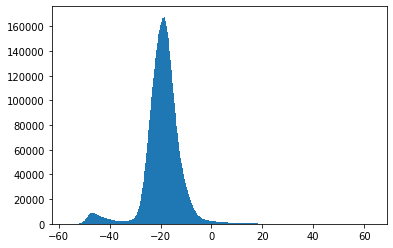

In [16]:
from skimage.filters import threshold_otsu, threshold_multiotsu

# compute an otsu threshold
p = plt.hist(image[~np.isinf(image)], bins=1000)
ot = threshold_multiotsu(image[~np.isinf(image)], classes=4, nbins=100)
ot = min(ot) # just take the minimum

print(f"Identified threshold according to Otsu: {ot}")

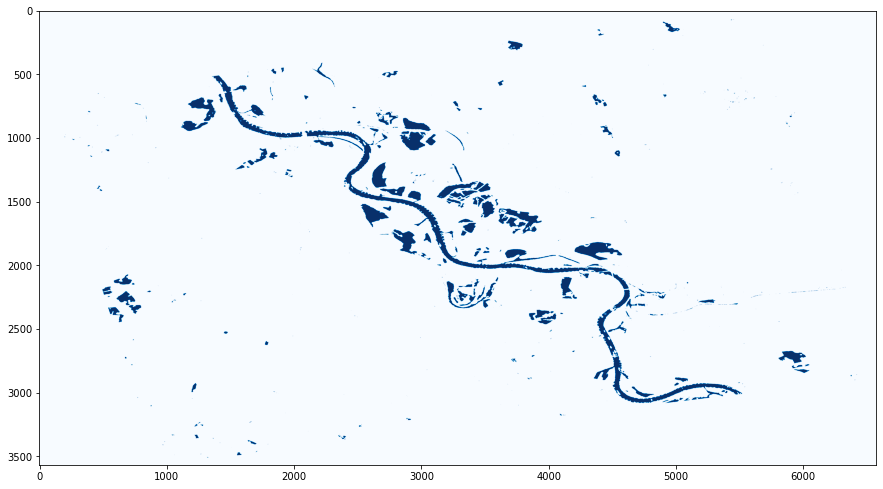

In [17]:
inf_mask = np.isinf(image)
water_mask = image.copy()
water_mask[inf_mask] = ot + 1
water_mask = water_mask < ot

plt.figure(figsize=(15,20))
plt.imshow(water_mask, cmap='Blues')
plt.show()

In [18]:
import folium

m = folium.Map(zoom_start=10)
m.fit_bounds(((image_bbox.bottom, image_bbox.left), (image_bbox.top, image_bbox.right)))

folium.raster_layers.ImageOverlay(
    image=water_mask,
    bounds=[[image_bbox.bottom, image_bbox.left], [image_bbox.top, image_bbox.right]],
    colormap=lambda x: (0, 0, x, max(-.7+x, 0))
).add_to(m)

m

In [19]:
with rasterio.open(s1_corrected_path) as src:
    profile = src.profile 
    
    profile.update(
        dtype=rasterio.uint8,
        count=1,
        compress='lzw')
    
    with rasterio.open('result.tif', 'w', **profile) as dst_dataset:
        dst_dataset.write(water_mask.astype(rasterio.uint8), 1)